# Bulding and testing MFEM

I decided to see if I could build and run MFEM on my macbook .

## Install procedure

This is what I ended up with:

* brew install metis hypre
* pip install pyglvis
* pip install mfem

The last one is officially only supported on linux, but it worked OK on my mac. (Did trigger and error on one of the miniapps, but worked OK, you can find my google doc install logbook [here](https://docs.google.com/document/d/1nu-_Hi8qrgwgcRPrfdyOGileOGqA9_RK3R1qeexGdsA/edit?usp=sharing). 

## Testing

Test it out using the example code from the readme:

https://github.com/mfem/PyMFEM

It does seem to work at least!

Size of linear system: 121


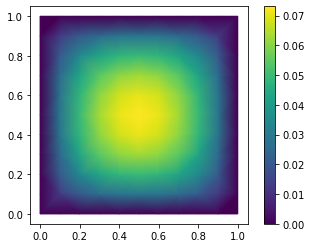

In [1]:
import mfem.ser as mfem

# create sample mesh for square shape
mesh = mfem.Mesh(10, 10, "TRIANGLE")

# create finite element function space
fec = mfem.H1_FECollection(1, mesh.Dimension())   # H1 order=1
fespace = mfem.FiniteElementSpace(mesh, fec)      

# 
ess_tdof_list = mfem.intArray()
ess_bdr = mfem.intArray([1]*mesh.bdr_attributes.Size())
fespace.GetEssentialTrueDofs(ess_bdr, ess_tdof_list)

# constant coefficient 
one = mfem.ConstantCoefficient(1.0)

# define Bilinear and Linear operator
a = mfem.BilinearForm(fespace)
a.AddDomainIntegrator(mfem.DiffusionIntegrator(one))
a.Assemble()
b = mfem.LinearForm(fespace)
b.AddDomainIntegrator(mfem.DomainLFIntegrator(one))
b.Assemble()

# create gridfunction, which is where the solution vector is stored
x = mfem.GridFunction(fespace);
x.Assign(0.0)

# form linear equation (AX=B)
A = mfem.OperatorPtr()
B = mfem.Vector()
X = mfem.Vector()
a.FormLinearSystem(ess_tdof_list, x, b, A, X, B);
print("Size of linear system: " + str(A.Height()))

# solve it using PCG solver and store the solution to x
AA = mfem.OperatorHandle2SparseMatrix(A)
M = mfem.GSSmoother(AA)
mfem.PCG(AA, M, B, X, 1, 200, 1e-12, 0.0)
a.RecoverFEMSolution(X, b, x)

# extract vertices and solution as numpy array
verts = mesh.GetVertexArray()
sol = x.GetDataArray()

# plot solution using Matplotlib

import matplotlib.pyplot as plt
import matplotlib.tri as tri

triang = tri.Triangulation(verts[:,0], verts[:,1])

fig1, ax1 = plt.subplots()
ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, sol, shading='gouraud')
fig1.colorbar(tpc)
plt.show()